<a href="https://colab.research.google.com/github/LauraSchellekens/TM10007_-private_-group/blob/master/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install sklearn numpy matplotlib


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [0]:
# General packages not sure anymore what I'm actually using lol
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn import svm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.impute import SimpleImputer
from sklearn import datasets, linear_model
from sklearn import datasets as ds

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter selection
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Learning curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [0]:
# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


X = data.drop('label', axis=1) # All data without column 'label'
Y = data['label'] 
Y.replace(('AD', 'CN'), (1, 0), inplace=True) # convert AD and CN to 1 and 0
AD = (list(data['label'] == 0)).count(True)
print(f'The number of AD patients: {AD}') # displays number AD patients
CN = (list(data['label'] == 0)).count(False)
print(f'The number of CN patients: {CN}') # displays number of CN patients 
percentage_AD=AD/(AD+CN)     # eventueel zeggen dat we features weggooien in de stap hieronder als er meer dan 20% mist, want AD is 40%????

The number of samples: 855
The number of columns: 268
The number of AD patients: 336
The number of CN patients: 519


In [0]:
# Preprocessing: drop feature if values are constant or too many are missing  

X = X.loc[:,X.apply(pd.Series.nunique) != 1]          # if column is constant, drop feature

X = X.replace(0, np.NaN)                              # replace 0 with NaN
X = X.replace(0.0,np.NaN)                             # just to be sure
missing_per_feature = X.isnull().sum()                # gives the amount of missing values (NaN) per feature
pct_null = missing_per_feature / len(X)               # gives percentage of missing values per feature
missing_features = pct_null[pct_null > 0.20].index    # gives features with more than 20% missing values
X.drop(missing_features, axis=1, inplace=True)        # remove feature if more than 20% missing values

missing_per_feature_max = max(X.isnull().sum())       # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete and constant features

print(missing_per_feature_max)
print (X.shape, Y.shape)

140
(855, 258) (855,)


In [0]:
# split into train (70%) and test (30%) set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(598, 258) (598,)
(257, 258) (257,)


In [0]:
# Preprocessing:  impute missing values (fill missing)

imputer = impute.SimpleImputer(strategy='mean')       # imputer with mean 
imputer.fit(X_train)                                  # fit the imputer to the train data
X_train_imp=imputer.transform(X_train)                # transform the X_train data with the trained imputer
X_train_imp = pd.DataFrame(data=X_train_imp, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df

X_test_imp = imputer.transform(X_test)                # apply imputer to test data   
X_test_imp = pd.DataFrame(data=X_test_imp, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df


In [0]:
# Preprocessing: scaling either standard or robust (removes median and scales data according to quantile range) 

scaler = preprocessing.StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)        # scaling the training data
X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df

X_test_scaled = scaler.transform(X_test_imp)          # scaling the test data
X_test_scaled = pd.DataFrame(data=X_test_scaled, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df

print(len(X_train_scaled))

598


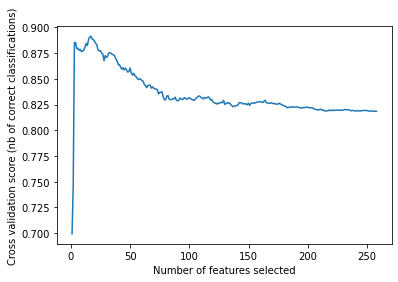

------------------------
0.8662207357859532
[  1  11  46  55  56  73  80 112 143 145 163 215 222 239 246 250 251]


,hf_energy,hf_entropy,hf_kurtosis,hf_max,hf_mean,hf_median,hf_min,hf_peak,hf_quartile_range,hf_range,hf_skewness,hf_std,logf_energy_sigma1,logf_energy_sigma10,logf_energy_sigma5,logf_entropy_sigma1,logf_entropy_sigma10,logf_entropy_sigma5,logf_kurtosis_sigma1,logf_kurtosis_sigma10,logf_kurtosis_sigma5,logf_max_sigma1,logf_max_sigma10,logf_max_sigma5,logf_mean_sigma1,logf_mean_sigma10,logf_mean_sigma5,logf_median_sigma1,logf_median_sigma10,logf_median_sigma5,logf_min_sigma1,logf_min_sigma10,logf_min_sigma5,logf_peak_sigma1,logf_peak_sigma10,logf_peak_sigma5,logf_quartile_range_sigma1,logf_quartile_range_sigma10,logf_quartile_range_sigma5,logf_range_sigma1,...,tf_NGTDM_Coarseness,tf_NGTDM_Complexity,tf_NGTDM_Contrast,tf_NGTDM_Strength,"vf_Frangi_edge_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_131_S_5138_bl_0,3.090734,-1.437720,1.389552,1.271423,1.655734,1.462763,2.083721,1.353698,-0.882551,-1.373754,0.191368,-1.232385,-0.791635,-0.663662,-0.707537,1.382804,0.150113,1.065988,-1.254366,-0.280606,-1.136785,-0.725725,-0.284126,0.477821,-0.485804,-0.746172,0.690941,-0.690166,-0.732046,0.363151,0.515202,0.383810,0.777859,-0.773318,-0.266719,-0.814517,1.286730,-0.590401,0.900145,-0.659085,...,3.785939,1.516212e-16,0.000000,0.000000,-0.171476,0.109928,-0.370187,-0.258396,0.214007,0.551979,-0.324806,-0.430362,0.126987,-0.248488,-0.719970,-0.199153,-0.171476,0.109928,-0.370187,-0.258396,0.214007,0.551979,-0.324806,-0.430362,0.126987,-0.248488,-0.719970,-0.199153,-0.255449,0.468338,-0.506506,-0.460569,-0.045738,1.977062e-01,-0.556456,-0.425712,-0.142868,-4.226652e-01,-1.464670e+00,-3.148371e-01
0_941_S_4066_bl_0,-0.411256,-0.072194,0.240820,-0.727889,-0.082997,-0.143755,0.203584,-0.700611,-0.615075,-0.784759,-0.740692,-0.753285,-0.944488,0.264211,-0.327610,-0.912273,-1.703050,-1.257671,0.377285,1.017164,0.493864,-0.257437,-0.835295,0.058658,1.159559,0.190335,0.141191,-0.035701,0.295458,-0.234002,1.006676,0.004926,0.186975,0.303888,0.846251,0.757628,-1.343435,-0.738722,-1.320325,-0.819851,...,-0.264135,-7.298475e-01,-0.537646,-0.169859,-0.670011,-0.272514,-0.535119,-0.691956,-0.806443,-1.020498,-0.700189,0.293742,-0.353635,-0.672002,-0.301692,-0.523717,-0.670011,-0.272514,-0.535119,-0.691956,-0.806443,-1.020498,-0.700189,0.293742,-0.353635,-0.672002,-0.301692,-0.523717,-0.279948,-0.963070,1.159328,-0.050423,-0.928085,-1.097877e+00,0.000000,-0.043179,-1

In [0]:
# Code for greedy feature selection through backward feature elimination
'''
First determine the best amount of features
'''

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear", random_state=None)

# classifications
rfecv = feature_selection.RFECV(estimator=svc,step=1,cv=model_selection.StratifiedKFold(5),scoring='roc_auc')
rfecv.fit(X_train_scaled,y_train)
X_train_best_array=rfecv.transform(X_train_scaled)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Print score and df of selected features
score = rfecv.score(X_train_scaled, y_train)
bestfeatures = rfecv.get_support(True)
XX=X_train_scaled.iloc[:,bestfeatures]
print('------------------------')
print(score)
print(bestfeatures)
XX
# rfecv.support_
# print(len(rfecv.ranking_))

X_train_scaled

In [0]:
# Code for feature selection
'''
With the amount of features desired known, find the best performing features
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
#apply SelectKBest class to extract top ... best features
best2 = SelectKBest(score_func= f_classif, k=4) # k= number of desired features
fit = best2.fit(XX,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(XX.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(4,'Score'))  #print ... best features 


                                Specs       Score
0                       (hf_entropy,)  431.706979
11               (tf_LBP_std_R3_P12,)  324.448974
1                           (hf_std,)  281.060828
5   (phasef_phasesym_entropy_WL3_N5,)  192.311688


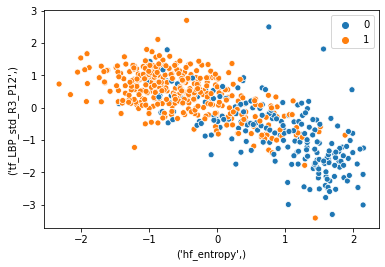

In [0]:
import seaborn
z1=XX
x1=z1.iloc[:,0]
z2=XX
x2=z2.iloc[:,11]
y = np.array(y_train)
seaborn.scatterplot(x=x1, y=x2, hue=y)

In [0]:
XX[:,12]


,hf_energy,hf_skewness,logf_peak_sigma1,logf_std_sigma1,tf_GLRLM_LowGrayLevelRunEmphasis,tf_GLSZM_ZoneEntropy,tf_Gabor_0.05A0.0mean,tf_Gabor_0.05A0.0min,tf_Gabor_0.2A0.0std,tf_Gabor_0.2A0.79mean,tf_Gabor_0.2A1.57std,tf_Gabor_0.5A2.36std,tf_LBP_peak_R8_P24,tf_LBP_std_R15_P36,tf_NGTDM_Strength,"vf_Frangi_edge_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0"
ID,,,,,,,,,,,,,,,,,
0_128_S_0245_bl_0,-0.251120,-1.286594,0.258879,0.504772,-0.235842,0.582933,-0.185194,-0.098327,0.094409,-0.781169,0.317373,0.493182,0.0,0.189020,-0.379052,1.068332,1.068332
0_098_S_0896_bl_0,-0.701875,-1.598479,0.088594,-0.699040,-0.332167,-0.039909,-0.406865,1.745291,0.203324,0.605055,0.189496,-0.052199,0.0,0.161977,-0.364654,-1.089302,-1.089302
0_135_S_4676_bl_0,-0.642326,0.501459,0.360634,-0.362920,-0.199377,-0.358791,0.208170,-1.003390,-0.041101,-1.293510,-0.777434,0.220093,0.0,0.103478,-0.380921,0.550965,0.550965
0_116_S_4092_bl_0,0.622116,-0.187122,1.259820,-0.682492,-0.706390,-0.431582,0.669923,-0.141446,0.865212,0.029410,0.241540,0.151582,0.0,0.560273,0.306475,-0.482179,-0.482179
0_099_S_0492_bl_0,-0.370044,2.202167,-0.862507,0.217176,1.148064,1.025174,-0.927013,-1.803931,-1.252942,-1.236945,1.280062,-0.125750,0.0,-1.183754,-0.427218,0.499030,0.499030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0_041_S_4041_bl_0,-0.112789,-0.786402,0.559992,-0.945442,-0.678461,-0.431582,-0.125255,1.113551,0.224708,0.677432,-0.481064,-0.930699,0.0,-0.248559,0.152138,-0.931666,-0.931666
0_036_S_5063_bl_0,0.524940,0.285332,2.551490,0.008766,-0.285824,0.468926,-2.241427,1.257148,-2.518532,-0.402855,1.557365,-0.915304,0.0,0.762662,-0.376995,1.070330,1.070330
0_137_S_0459_bl_0,-0.513542,0.246093,-0.112840,-1.245794,-0.447484,0.902952,-0.158834,0.253609,-0.620664,0.713871,0.032559,-0.458897,0.0,-0.057307,-0.346519,-0.221190,-0.221190


In [0]:
# Random Forest Classifier

# Set parameters
parameters = {"n_estimators": list(range(1, 20, 2))}
    # nog een range kiezen

score = 'balanced_accuracy'

print('# Random Forest Classifier')
print()
rfc = RandomForestClassifier()
grid_search = GridSearchCV(
    rfc, parameters, scoring=score
) 
# cv is nu default, dus een kfold van 5! 
grid_search.fit(X_train_scaled, y_train)

clf = grid_search.best_estimator_
best_parameters = grid_search.best_params_
print(f"Best parameters set found on development set: {best_parameters}")
print()
score = grid_search.best_score_
print(f"Grid score on development set: {score}")
print()


# Random Forest Classifier

Best parameters set found on development set: {'n_estimators': 19}

Grid score on development set: 0.7885398102903133



In [0]:
# Support Vector Machine Classifier

# Set parameters
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-2],
                     'C': list(range(1, 20, 1))},
              {'kernel':['linear'], 'C': list(range(1, 20, 1))}]

score='balanced_accuracy'

print('# Support Vector Machine Classifier')
print()
svc = SVC()
grid_search = GridSearchCV(
    svc, parameters, scoring=score
) 
# cv is nu default, dus een kfold van 5! 
grid_search.fit(X_train_scaled, y_train)

clf = grid_search.best_estimator_
best_parameters = grid_search.best_params_
print(f"Best parameters set found on development set: {best_parameters}")
print()
score = grid_search.best_score_
print(f"Grid score on development set: {score}")
print()

# Support Vector Machine Classifier

Best parameters set found on development set: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}

Grid score on development set: 0.8002356999137683



In [0]:
# K Nearest Neighbour Classifier

# Set parameters
parameters = {"n_neighbors": list(range(1, 50, 2))}

score = 'balanced_accuracy'

print("# K Nearest Neighbour Classifier")
print()
knn = KNeighborsClassifier(weights='distance')
grid_search = GridSearchCV(
    knn, parameters, scoring=score
) 
# cv is nu default, dus een kfold van 5! 
grid_search.fit(X_train_scaled, y_train)

clf = grid_search.best_estimator_
best_parameters = grid_search.best_params_
print(f"Best parameters set found on development set: {best_parameters}")
print()
score = grid_search.best_score_
print(f"Grid score on development set: {score}")
print()



# K Nearest Neighbour Classifier

Best parameters set found on development set: {'n_neighbors': 9}

Grid score on development set: 0.7662747916067835



In [0]:
# test data
print('# Evaluate with test data set')
y_true, y_pred = y_test, clf.predict(X_test_scaled)

auc=metrics.roc_auc_score(y_true, y_pred)
print(f'AUC:{auc}')
accuracy=metrics.balanced_accuracy_score(y_true, y_pred)
print(f'accuracy:{accuracy}')
F1=metrics.f1_score(y_true,y_pred)
print(f'F1:{F1}')
precision=metrics.precision_score(y_true,y_pred)
print(f'precision:{precision}')
recall=metrics.recall_score(y_true, y_pred)
print(f'recall:{recall}')

# Evaluate with test data set
AUC:0.7577452667814113
accuracy:0.7577452667814113
F1:0.8184615384615385
precision:0.8364779874213837
recall:0.8012048192771084


In [0]:
# Function for learning curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

<Figure size 1728x576 with 0 Axes>

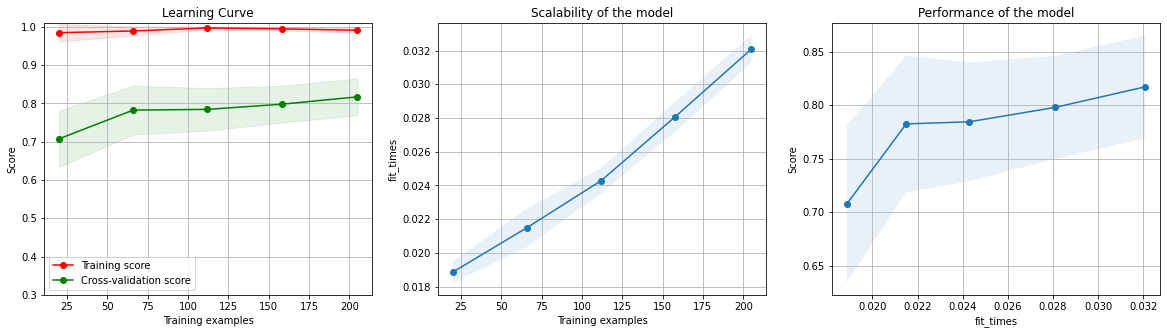

In [0]:
# Learning Curve

clf = RandomForestClassifier(n_estimators=13)
# Hier dan eigenlijk de beste classifier die we eruit krijgen en testen op de test set)

X = X_test_scaled
Y = y_test

# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# Make figure
title = 'Learning Curve'
fig = plt.figure(figsize=(24,8))
plot_learning_curve(clf, title, X, Y, ylim=(0.3, 1.01), cv=cv)